# Industry Accelerators - Customer Life Event Prediction Models

## Introduction
In this notebook, we build machine learning models to predict the likelihood of significant <b>life events</b> experienced by clients. We focus on two specific life events, `LFE_RELOCATION` and `LFE_HOME_PURHCASE`.  


Before executing this notebook on IBM Cloud, you need to:<br>
1) When you import this project on an IBM Cloud environment, a project access token should be inserted at the top of this notebook as a code cell. <br>
If you do not see the cell above, Insert a project token: Click on **More -> Insert project token** in the top-right menu section and run the cell. <br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
2) Provide your IBM Cloud API key in the subsequent cell.<br>
3) You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>


#### Insert IBM Cloud API key
Your Cloud API key can be generated by going to the [API Keys section of the Cloud console](https://cloud.ibm.com/iam/apikeys). From that page, scroll down to the API Keys section, and click Create an IBM Cloud API key. Give your key a name and click Create, then copy the created key and paste it below. 

If you are running this notebook on cloud pak for data on-prem, leave the ibmcloud_api_key field blank.

In [2]:
ibmcloud_api_key = ''

In [3]:

try:
    project
except NameError:
    # READING AND WRITING PROJECT ASSETS
    import project_lib
    project = project_lib.Project() 

In [4]:
!pip install chart_studio
import pandas as pd
import time
pd.set_option('display.max_columns', 500)
from chart_studio.plotly import iplot
import plotly as py
py.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import pickle 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


#### Load the prepped data 
Read the data that was prepared in the previous notebook.

In [5]:

prepped_data = pickle.load(open('prepared_data.pkl', 'rb'))

### Splitting the Data
We set up our feature inputs and outcome variable also called the $X$ and $y$ values. Our $X$ values will be the features we use in our model while $y$ is the output or what we'll try and predict. After we set up the appropriate $X$ and $y$ values then we split our data into train and test data sets using a common 80:20 split with 80% of the data being used for training our model and 20% being held out to test or validate our model.

When we split our datset we want to do a stratified sampling using our outcome variable with the `stratify=y_output` parameter. This ensures that when we split our dataset we maintain the proportions or balance of the outcome variable, `y_output`, from the original dataset within both train and test datasets.

Finally, we set the seed using the `random_state=1234` parameter, for reproducibility purposes.

In [6]:
from sklearn.model_selection import train_test_split

split_data = {}

for event_type, training_data in prepped_data.items():
    
    X_inputs = training_data.drop(['TARGET'], axis=1)
    y_output = training_data['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X_inputs, y_output, stratify=y_output, test_size=0.20, random_state=1234)
    
    split_data[event_type] = {
        'X_train': X_train, 'y_train': y_train,
        'X_test':  X_test,  'y_test':  y_test
    }

for event_type, splits in split_data.items():
    print("{} Train and Test Data Dimensions:".format(event_type))
    for split, df in splits.items():
        print("{} shape: {}".format(split, df.shape))
    print()

LFE_RELOCATION Train and Test Data Dimensions:
X_train shape: (361, 52)
y_train shape: (361,)
X_test shape: (91, 52)
y_test shape: (91,)

LFE_HOME_PURCHASE Train and Test Data Dimensions:
X_train shape: (383, 65)
y_train shape: (383,)
X_test shape: (96, 65)
y_test shape: (96,)



## Building Machine Learning Models
 The final phase, and the most fun part, is the modelling. We'll train and validate 3 types of models:<br>
 1. Logistic Regression
 2. Random Forests
 3. Gradient Boosting for Classification
 
For each of these models we'll fit our model and test the model showing accuracy metrics for both the training and testing data. Then we'll look at the confusion matrices, for both train and test data, to see where the model is classifying best across the binary labels. Finally, for the random forests and the gradient boosting models, we'll look at the variable importance plots. Let's take a look at training these models and their accuracies.

### Model Fitting
First step is to build the classifier and then fit a classifier on your $X$ and $y$ training data for both our datasets, Home Purchase and Relocation. Let's fit the 3 models mentioned above.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {}
y_scores = {}

for event_type, splits in split_data.items():
    clf = {}
    ys = {}
    
    # Random Forests
    clf['RandomForest'] = RandomForestClassifier(n_estimators=500, max_depth=9, random_state=1234)
    ys['RandomForest'] = clf['RandomForest'].fit(splits['X_train'], splits['y_train'])
    
    # Gradient Boosting
    clf['GradientBoosting'] = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=12, random_state=1234)
    ys['GradientBoosting'] = clf['GradientBoosting'].fit(splits['X_train'], splits['y_train'])
    
    # Logistic Regression
    clf['LogisticRegression'] = LogisticRegression(penalty='l1', solver='saga', tol=0.1, random_state=1234)
    ys['LogisticRegression'] = clf['LogisticRegression'].fit(splits['X_train'], splits['y_train'])
    
    # save models and sores to dictionary
    models[event_type] = clf
    y_scores[event_type] = ys

models

{'LFE_RELOCATION': {'RandomForest': RandomForestClassifier(max_depth=9, n_estimators=500, random_state=1234),
  'GradientBoosting': GradientBoostingClassifier(learning_rate=0.01, max_depth=12, n_estimators=500,
                             random_state=1234),
  'LogisticRegression': LogisticRegression(penalty='l1', random_state=1234, solver='saga', tol=0.1)},
 'LFE_HOME_PURCHASE': {'RandomForest': RandomForestClassifier(max_depth=9, n_estimators=500, random_state=1234),
  'GradientBoosting': GradientBoostingClassifier(learning_rate=0.01, max_depth=12, n_estimators=500,
                             random_state=1234),
  'LogisticRegression': LogisticRegression(penalty='l1', random_state=1234, solver='saga', tol=0.1)}}

### Plot Confusion Matrices
The accuracy looks pretty good, but we also want to see where the model is misclassifying across our binary labels. For that we'll look at our confusion matrix.

**`plot_confusion_matrix`**: This function plots an annotated and more presentable confusion matrix for the classification model results.

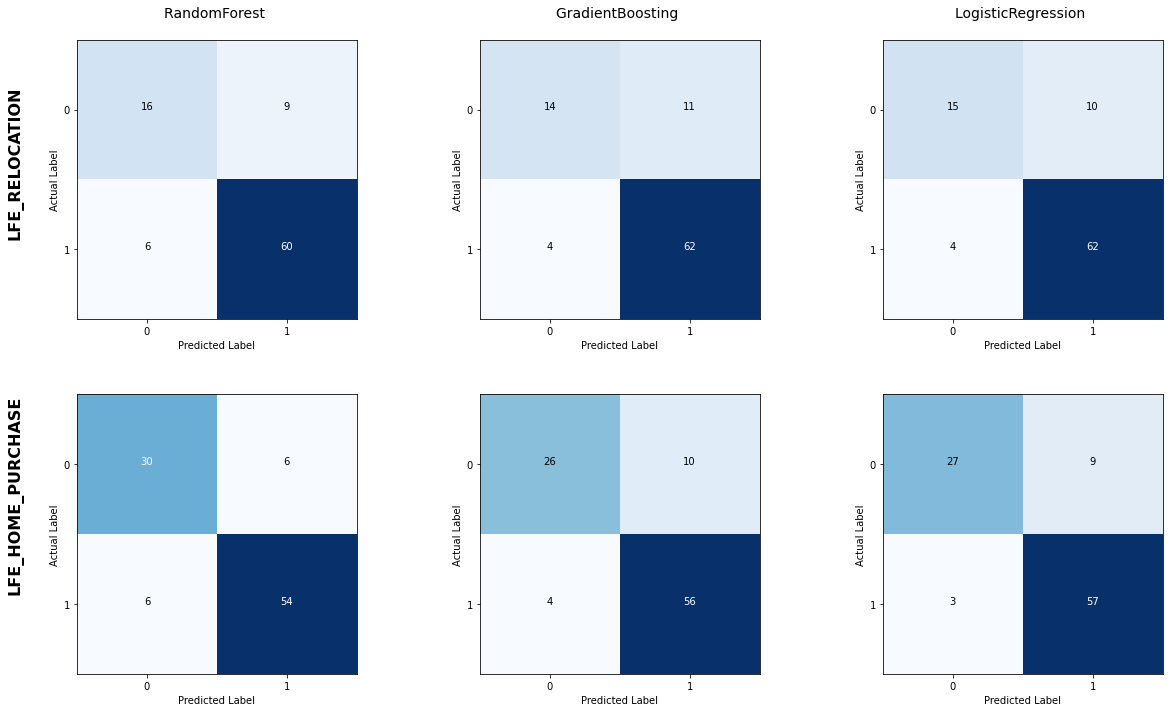

In [8]:
from sklearn import metrics
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Function to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Iterate over event and model types, calculating and then plotting confusion matrices
fig = plt.figure(figsize=(20,10))
plot = 1
for event_num, (event_type, model_types) in enumerate(models.items()):
    split = split_data[event_type]
    for model_num, (model_type, model) in enumerate(model_types.items()):
        y_pred_test = model.predict(split['X_test'])
        confusion_matrix = metrics.confusion_matrix(split['y_test'], y_pred_test, labels=[0,1])
        
        fig.add_subplot(230+plot)
        if model_num==0:
            plt.text(-1,0.9,event_type, rotation=90, fontsize=16, fontweight="bold")
        plot_confusion_matrix(confusion_matrix, normalize=False, classes=['0','1'], title=(model_type if event_num==0 else '')+' \n')
        plot += 1

### View Model Test Accuracies

There are several metrics of model performance that we can check. For this project, we choose to view the model accuracy for each model.

In [9]:
acc = {}
for event_type, model_types in models.items():
    acc[event_type] = {}
    split = split_data[event_type]
    for model_type, model in model_types.items():
        acc[event_type][model_type] = round(model.score(split['X_test'], split['y_test']),4)

print("\nModel Test Accuracy : ")
pd.DataFrame(acc)


Model Test Accuracy : 


,LFE_RELOCATION,LFE_HOME_PURCHASE
RandomForest,0.8352,0.8750
GradientBoosting,0.8352,0.8542
LogisticRegression,0.8462,0.8750


### Select Best Model For Each Event Type

Based on the accuracy metric, select the best model for each event type.

In [10]:
best_models = {}
for event_type, model_types in models.items():
    best_models[event_type] = {'accuracy': 0}
    for model_type, model in model_types.items():
        if acc[event_type][model_type] > best_models[event_type]['accuracy']:
            best_models[event_type] = {
                'model_type': model_type,
                'model': models[event_type][model_type],
                'accuracy': acc[event_type][model_type]
            }

print('\nBest Models:')
pd.DataFrame(best_models).T.drop(['model'], axis=1)[['model_type', 'accuracy']]


Best Models:


,model_type,accuracy
LFE_RELOCATION,LogisticRegression,0.8462
LFE_HOME_PURCHASE,RandomForest,0.875


### Override Selected Models

If you would like to select a different class of model to be used, set the `override` dict with the event types mapping to the model types you would like to use for the respective event types.

In our case we selected `'RandomForest'` for both models so that we can show explainability during model scoring.

In [11]:
b_use_census_data = True

if b_use_census_data:
    override = {}
else:
    override = {'LFE_RELOCATION': 'RandomForest'}
for event_type, model_type in override.items():
    best_models[event_type] = {
        'model_type': model_type,
        'model': models[event_type][model_type],
        'accuracy': acc[event_type][model_type]
    }

print('\nSelected Models:')
pd.DataFrame(best_models).T.drop(['model'], axis=1)[['model_type', 'accuracy']]


Selected Models:


,model_type,accuracy
LFE_RELOCATION,LogisticRegression,0.8462
LFE_HOME_PURCHASE,RandomForest,0.875


### Plot Feature Importance

With decision tree models, you can view variable importance plots. These plots indicate, at the feature level, some importance for the variable to classify the outcome variable. It uses gini importance which looks at node impurity. Node impurity is just looking at how well a tree splits the data.

We'll take a look at the feature importance plots for the best performing models for both events, Home Purchase and Relocation. Random forest was the top model for both events.

**`plot_feature_importance`**: This plots an annotated and more presentable variable importance plot for the top 10 variables.

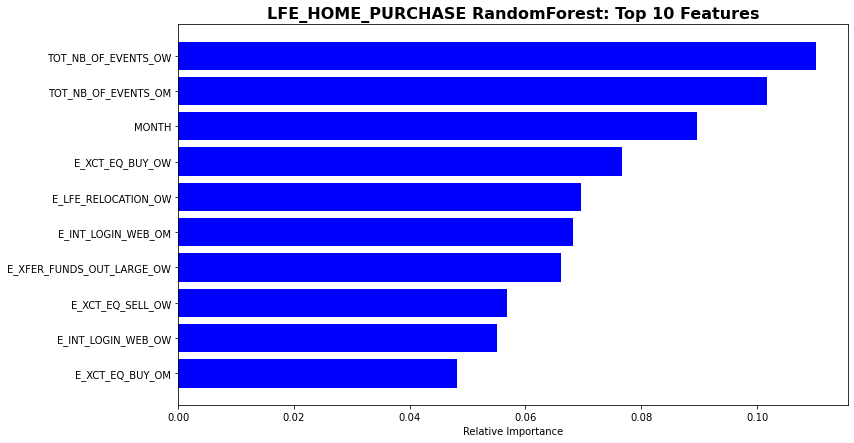

In [12]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    

# Iterate over best models and show features importance if possible
for event_type, best_model in best_models.items():
    if best_model['model_type'] != 'LogisticRegression':
        plot_feature_importance(feature_list=split_data[event_type]['X_train'].columns.tolist(), 
                                feature_importances=best_model['model'].feature_importances_, 
                                title="{} {}: Top 10 Features".format(event_type, best_model['model_type']))

### Save the best classification model to Cloud Pak for Data

We select the top performing model for each product. In the next steps we save and deploy the models. 

Before we save the model, we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space. 

If you do not have a space already created, you can use the Deployment Spaces Dashboard to create one.

- Navigate to Deployments
- Click New Deployment Space
- Enter Deployment space name
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy space name and paste it below 

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.


### User Inputs

The user can specify the name for the space, models and model deployments.  <br>


In [13]:
# Specify a name for the space being created, the saved models and the model deployments
space_name = 'Customer Life Event Space'
model_names = {}
deployment_names = {}
for event_type, _ in best_models.items():
    model_names[event_type] = 'life_event_' + event_type + '_model'
    deployment_names[event_type] = 'life_event_' + event_type + '_model_deployment'


Below code imports `ibm-watson-machine-learning` library and then creates a wml client using the credentials provided.

In [14]:
from ibm_watson_machine_learning import APIClient

import os 
if ibmcloud_api_key != '':
    wml_credentials = {
        "apikey": ibmcloud_api_key,
        "url": 'https://' + os.environ['RUNTIME_ENV_REGION'] + '.ml.cloud.ibm.com'
    }
else:
    token = os.environ['USER_ACCESS_TOKEN']
    wml_credentials = {
        "token": token,
        "instance_id" : "openshift",
        "url": os.environ['RUNTIME_ENV_APSX_URL'],
        "version": "3.5"
     }
client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space, using the name of the space as specified in the user inputs cell above. The space name will be used in the future to identify this space. 

By default, if the space name already exists, the existing space will be used to store and deploy models and functions. As mentioned before, the **use_exisiting_space** parameter can be set to **False** to create a new space and replace the exisiting one.

In [15]:
space_uid=""
for space in client.spaces.get_details()['resources']:
    if space['entity']['name'] == space_name:
        print("Deployment space with ",space_name," exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        print("Using the existing space")
            
            
if space_uid=="":
    if ibmcloud_api_key == '':
        # create the space and set it as default
        space_meta_data = {
            client.spaces.ConfigurationMetaNames.NAME : space_name

            }

        stored_space_details = client.spaces.store(space_meta_data)

        space_uid = stored_space_details['metadata']['id']

        client.set.default_space(space_uid)
    
    else:
        print("Deployment space",space_name, "doesn't exist, Please create a new deployment space before continue..")
        raise Exception("Deployment space doesn't exist")

Deployment space with  Customer Life Event Space  exists . .
Using the existing space


### Store the Model details

Store the random forest model in the deployment space. The name for the model is specified in the user inputs cell above. Software specification and default tag for the model are specified in the model metadata. <br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the `default_py3.7` software specification to store the models. We get the ID of the software specification and include it in the metadata when storing the model. Available Software specifications can be retrieved using `client.software_specifications.list()`. 

In [16]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

stored_model_details_dict = {}
for event_type, best_model in best_models.items():
    metadata = {
        client.repository.ModelMetaNames.NAME: model_names[event_type],
        client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid,
        client.repository.ModelMetaNames.TAGS: ['life_event_' + event_type + '_model_tag']
    }
    stored_model_details = client.repository.store_model(model=best_model['model'], meta_props=metadata, training_data=split_data[event_type]['X_train'], training_target=split_data[event_type]['y_train'], feature_names = list(split_data[event_type]['X_train'].columns))
    # store the model details in a dictionary
    stored_model_details_dict[event_type] = stored_model_details
stored_model_details

{'entity': {'label_column': 'TARGET',
  'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
     'endpoint_url': 'not_applicable',
     'secret_access_key': 'not_applicable'},
    'id': '1',
    'location': {},
    'schema': {'fields': [{'name': 'E_ACNT_SEC_OPEN_*_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY26_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY27_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY28_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY32_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY35_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY36_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY39_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY40_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY42_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY43_OW', 'type': 'float64'},
      {'name': 'E_BIRTHDAY44_OW', 'type': 'floa

### Deploy the Model 

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata.

In [17]:
# Meta_props for the model deployment

for event_type, best_model in best_models.items():
    
    meta_props = {
        client.deployments.ConfigurationMetaNames.NAME: deployment_names[event_type],
        client.deployments.ConfigurationMetaNames.TAGS : ['life_event_' + event_type + '_deployment_tag'],
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    
    model_uid = stored_model_details_dict[event_type]["metadata"]["id"]
    client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: '9d34161c-249b-43db-b3f3-6fdbab74a1ab' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f1467555-3131-4efa-a084-b88bf5afa9bb'
------------------------------------------------------------------------------------------------




#######################################################################################

Synchronous deployment creation for uid: '0a86ec31-e562-4071-9d39-45844782099b' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deploy

### Operationalize the models

Now we are ready to operationlize our best model. See notebook `3-model-scoring` for the next step.

<hr>

Sample Materials, provided under <a href="https://github.com/IBM/Industry-Accelerators/blob/master/CPD%20SaaS/LICENSE" target="_blank" rel="noopener noreferrer">license.</a> <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>